In [2]:
#cd \\new-monster\t\PreyCapture\ENRICHMENT_ALL\Enrichment_Cohort4

\\new-monster\t\PreyCapture\ENRICHMENT_ALL\Enrichment_Cohort4


In [9]:
cd D:\gdrive\enrichment_prey_capture\Tracks_11_22_17

D:\gdrive\enrichment_prey_capture\Tracks_11_22_17


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import ssm
import sklearn.manifold as manifold

In [13]:
data = np.genfromtxt('compiled_preycapture_celltypes.csv' ,delimiter=',')

condAll = data[:,3].copy()
sessAll = data[:,4].copy()

data_norm = data[:,0:3].copy()
# for enrichment
#data_norm[:,0] = np.abs(data_norm[:,0]/180);
#data_norm[:,1] = data_norm[:,1]/600;
#data_norm[:,2] = data_norm[:,2]/10;

# for Hoy et al 2019 data
data_norm[:,0] = np.abs(data_norm[:,0]/180);
data_norm[:,1] = data_norm[:,1]/1200;
data_norm[:,2] = data_norm[:,2]/40;

#data_norm[data_norm[:,2]<0.04,2]=0.04;
#data_norm[:,1] = np.log(data_norm[:,1])
#data_norm[:,2] = np.log(data_norm[:,2])


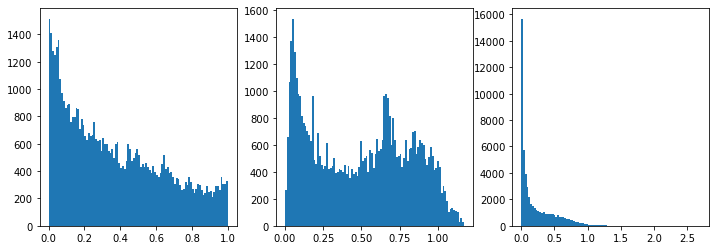

In [14]:
plt.figure(figsize = (12,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.hist(data_norm[:,i],100)
    

  0%|          | 0/20 [00:00<?, ?it/s]

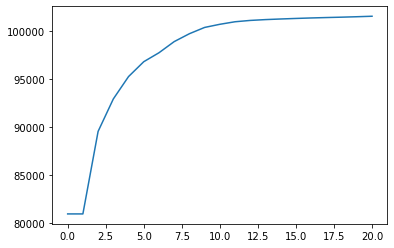

In [53]:
K = 6;
D = np.size(data_norm,1)
N_iters = 20
#test_hmm = ssm.HMM(K, D, observations="diagonal_gaussian")
test_hmm = ssm.HMM(K, D, observations="gaussian")


lls = test_hmm.fit(np.abs(data_norm), num_iters=N_iters,  init_method="kmeans")
zhat = test_hmm.most_likely_states(data_norm)
plt.plot(lls)

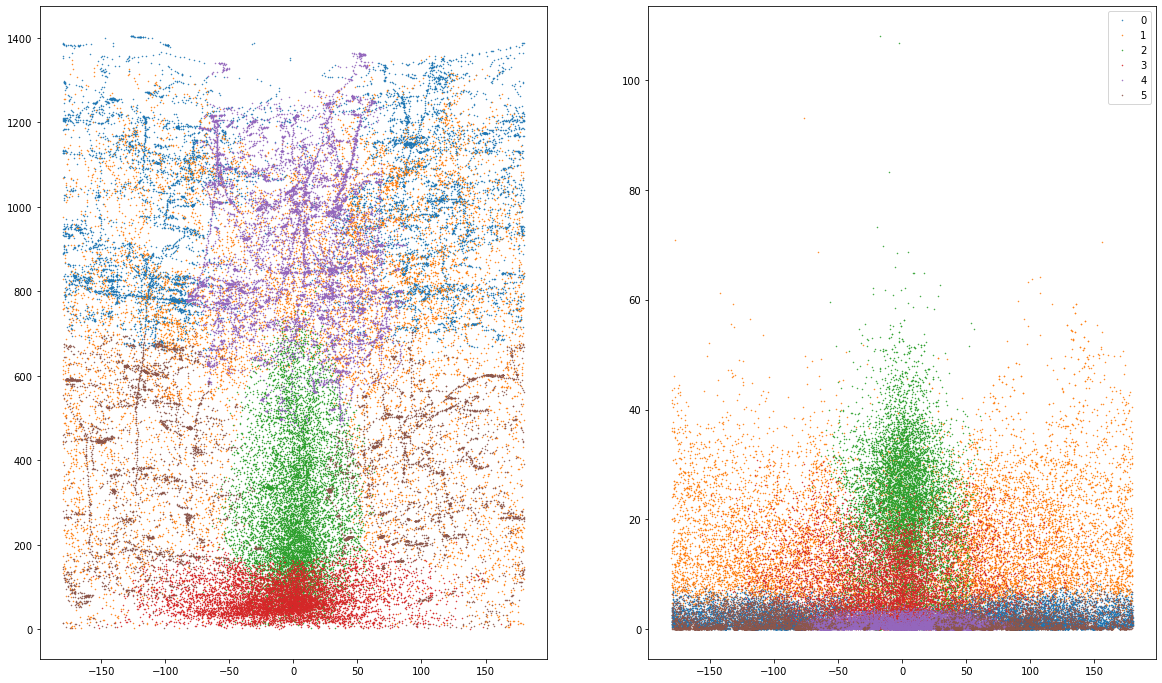

In [64]:
fig, axs = plt.subplots(1,2, figsize = (20,12))
for z in range(K):
    axs[0].plot(data[zhat==z,0],data[zhat==z,1],'.', markersize = 1,label = str(z))
    axs[1].plot(data[zhat==z,0],data[zhat==z,2],'.', markersize = 1, label = str(z))  
plt.legend()

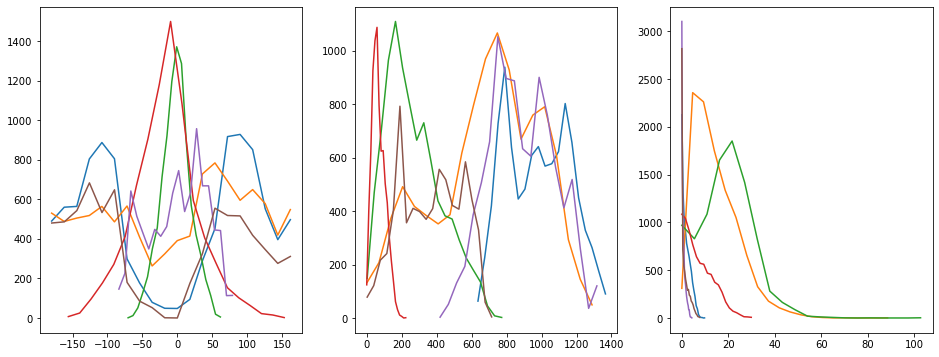

In [62]:
plt.figure(figsize = (16,6))
for i in range(3):
    plt.subplot(1,3,i+1)
    for z in range(K):
        h,b = np.histogram(data[zhat==z,i],bins = 20)
        plt.plot(b[:-1],h)

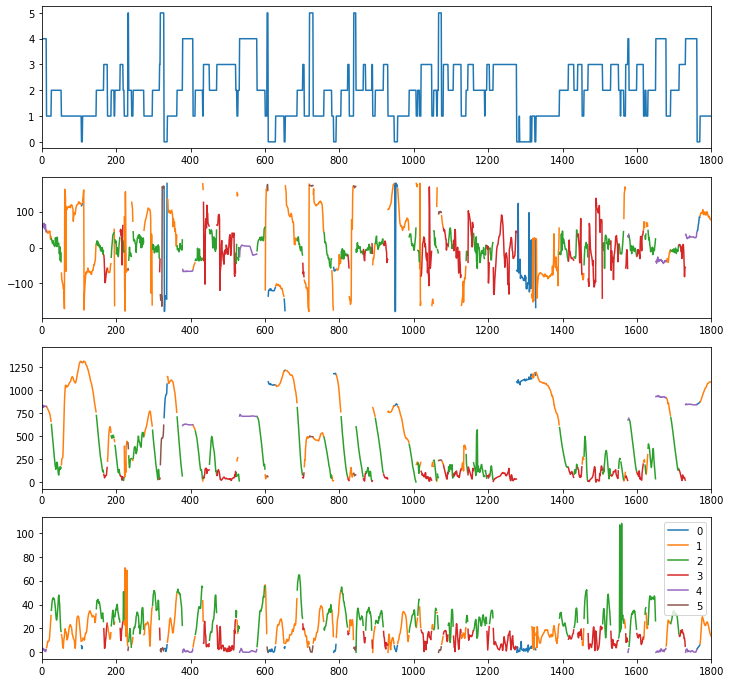

In [60]:
zhat = test_hmm.most_likely_states(data_norm)
xrange = (60*0,60*30)
plt.figure(figsize = (12,12))
plt.subplot(4,1,1)
plt.plot(zhat);
plt.xlim(xrange)
for i in range(3):
    plt.subplot(4,1,i+2)
    for z in range(K):
        d = data[:,i].copy();
        d[zhat!=z] = np.nan;
        plt.plot(d, label = str(z))
        plt.xlim(xrange)
plt.legend()

In [56]:

#test_hmm.permute([3, 0, 5, 1, 4, 2])  # enrichment data
test_hmm.permute([2, 5, 3, 4, 1, 0]) 

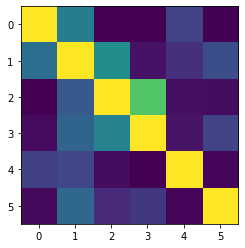

In [57]:
tm = test_hmm.transitions.transition_matrix
plt.imshow(tm, vmin = 0, vmax = 0.05)

In [43]:
test_hmm.permute(perm = [5, 4, 3, 2, 1, 0])

In [63]:
ncond = 4;
meanT = np.zeros((K,ncond))
for z in range(K):
    for c in range(ncond):
        meanT[z,c] = (np.sum((zhat==z) & (condAll==c+1)))/np.sum(condAll==c+1)
meanT

array([[0.04760788, 0.22890733, 0.15982706, 0.06956672],
       [0.20966229, 0.18550352, 0.2081196 , 0.18712239],
       [0.34146341, 0.12737931, 0.17206507, 0.26480235],
       [0.26313321, 0.12020022, 0.15858127, 0.17641982],
       [0.09638837, 0.19439505, 0.22548732, 0.03348869],
       [0.04174484, 0.14361457, 0.07591968, 0.26860003]])

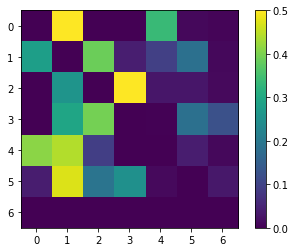

In [61]:
trans_mtx = np.zeros((K+1,K+1))
this_sess = sessAll[condAll>0]
for s in np.unique(this_sess):
    this_z = zhat[sessAll ==s]
    for i in range(len(this_z)-1):
        trans_mtx[this_z[i],this_z[i+1]] = trans_mtx[this_z[i],this_z[i+1]] + 1;
    trans_mtx[this_z[-1],K] = trans_mtx[this_z[-1],K] + 1
for i in range(K):
    trans_mtx[i,i]=0;
    trans_mtx[i,:] = trans_mtx[i,:] / np.sum(trans_mtx[i,:])
    #trans_mtx[i,i] = 1 - trans_mtx[i,i];
#plt.imshow(trans_mtx /len(np.unique(this_sess)), vmax = 5)
plt.imshow(trans_mtx, vmax = 0.5)
plt.colorbar()
stand_trans = trans_mtx.copy();    
#print(trans_mtx/len(np.unique(this_sess)))

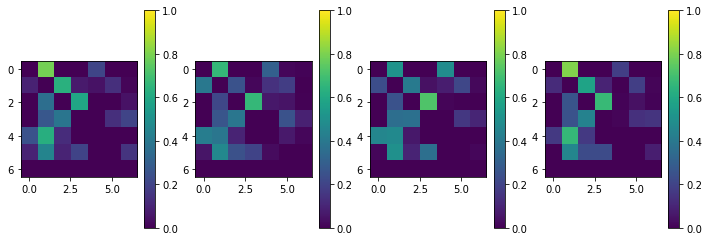

In [84]:
plt.figure(figsize = (12,4))
for c in range(ncond):
    trans_mtx = np.zeros((K+1,K+1))
    this_sess = sessAll[condAll==c+1]
    for s in np.unique(this_sess):
        this_z = zhat[sessAll ==s]
        for i in range(len(this_z)-1):
            trans_mtx[this_z[i],this_z[i+1]] = trans_mtx[this_z[i],this_z[i+1]] + 1;
        trans_mtx[this_z[-1],K] = trans_mtx[this_z[-1],K] + 1
    for i in range(K):
        trans_mtx[i,i]=0;
        trans_mtx[i,:] = trans_mtx[i,:] / np.sum(trans_mtx[i,:])
        #trans_mtx[i,i] = 1-trans_mtx[i,i];
    #plt.imshow(trans_mtx /len(np.unique(this_sess)), vmax = 5)
    plt.subplot(1,ncond,c+1)
    plt.imshow(trans_mtx, vmax = 1)
    plt.colorbar()
#ee_trans = trans_mtx.copy();    
#print(trans_mtx/len(np.unique(this_sess)))

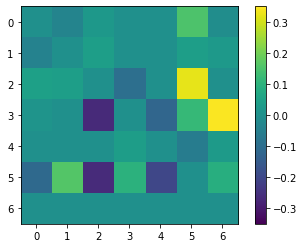

In [159]:
plt.imshow((ee_trans - stand_trans)/ (ee_trans+0.1), vmin = -0.35, vmax = 0.35)
plt.colorbar()

In [63]:
trans_pts

(array([    21,     79,    168, ..., 107821, 107858, 107872], dtype=int64),)

In [91]:
len(this_z)

70619